In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from plot_utils import make_plots

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load LHCO data

In [2]:
from data_utils import load_data, extract_regions, split_data

In [ ]:
features_sig=pd.read_hdf("LHCO/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5")
features_bg=pd.read_hdf("LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")

In [3]:
# dataset_bg=load_data(features_bg)
# dataset_sig=load_data(features_sig)

dataset_bg=np.load("saved_data/bg_data.npy")
dataset_sig=np.load("saved_data/sig_data.npy")

SR_low = 3.3
SR_high = 3.7
SB_low = 2.4
SB_high = 4.6

SR, SB = extract_regions(SR_low, SR_high, SB_low, SB_high, dataset_bg, dataset_sig)
(X_bg_SR, X_sig_SR) = SR
(X_bg_SB, X_sig_SB) = SB

In [4]:
X_train, X_bg_test = split_data(X_bg_SR) ## all background
y_train = np.zeros(len(X_train))

y_bg_test = np.zeros(len(X_bg_test))
X_sig = X_sig_SR ## all signal
y_sig = np.ones(len(X_sig))
X_test = np.concatenate((X_bg_test, X_sig))
y_test = np.concatenate((y_bg_test, y_sig))

# Autoencoder

In [5]:
from models.autoencoder import autoencoder, reconstruction_error

In [12]:
autoencoders = [autoencoder() for _ in range(10)]
histories = [ae.fit(X_train, X_train, epochs=1) for ae in autoencoders]
autoencoder_scores = [reconstruction_error(ae, X_test) for ae in autoencoders]

3034/3034 [==============================] - 8s 2ms/step - loss: 0.0162


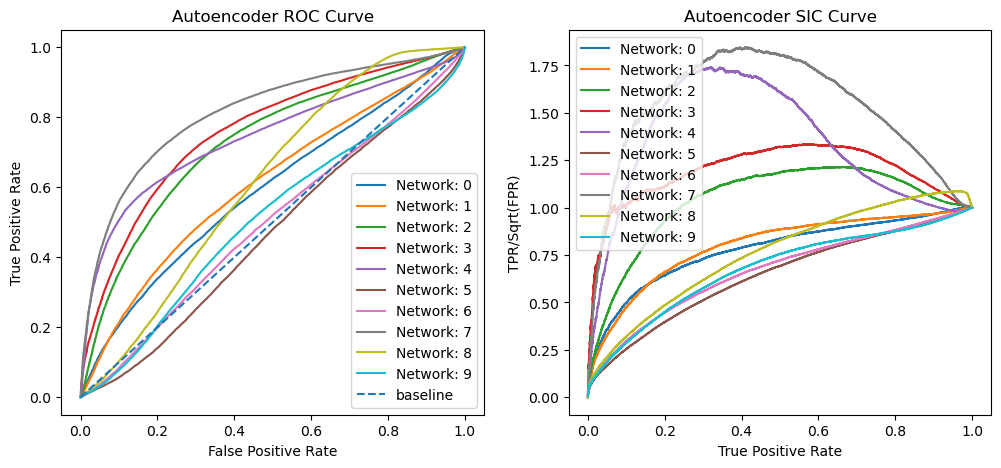

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
make_plots(ax1, ax2, autoencoder_scores, y_test, "Autoencoder")
fig.show()

# OCD

In [13]:
from models.ocd import OCD

In [16]:
ocds = [OCD() for _ in range(10)]
histories = [ocd.fit(X_train, y_train, epochs=5) for ocd in ocds]
ocd_scores = [ocd.predict(X_test) for ocd in ocds]

Epoch 1/5
3034/3034 [==============================] - 2s 717us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 2/5
3034/3034 [==============================] - 2s 712us/step - loss: 6.3365e-10 - accuracy: 1.0000
Epoch 3/5
3034/3034 [==============================] - 2s 710us/step - loss: 1.6391e-10 - accuracy: 1.0000
Epoch 4/5
3034/3034 [==============================] - 2s 714us/step - loss: 6.9713e-11 - accuracy: 1.0000
Epoch 5/5
3034/3034 [==============================] - 2s 709us/step - loss: 3.9245e-11 - accuracy: 1.0000
Epoch 1/5
3034/3034 [==============================] - 2s 706us/step - loss: 0.0012 - accuracy: 0.9997
Epoch 2/5
3034/3034 [==============================] - 2s 716us/step - loss: 9.5619e-09 - accuracy: 1.0000
Epoch 3/5
3034/3034 [==============================] - 2s 709us/step - loss: 1.6682e-09 - accuracy: 1.0000
Epoch 4/5
3034/3034 [==============================] - 2s 711us/step - loss: 4.1754e-10 - accuracy: 1.0000
Epoch 5/5
3034/3034 [========================

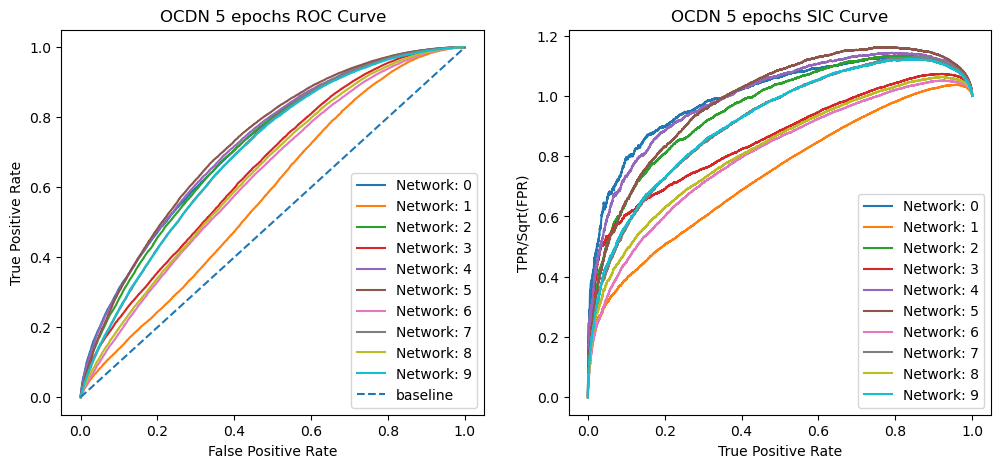

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
make_plots(ax1, ax2, ocd_scores, y_test, "OCDN 5 epochs")
fig.show()

# OC-SVM

In [21]:
from models.oc_svm import OAD, IAD

In [22]:
# warning: This code chunk takes a while to run

oad = OAD()
iad = IAD()

oad.fit(X_train)
iad.fit(X_train)

In [33]:
oad_scores = oad.scores(X_test)
iad_scores = iad.scores(X_test)

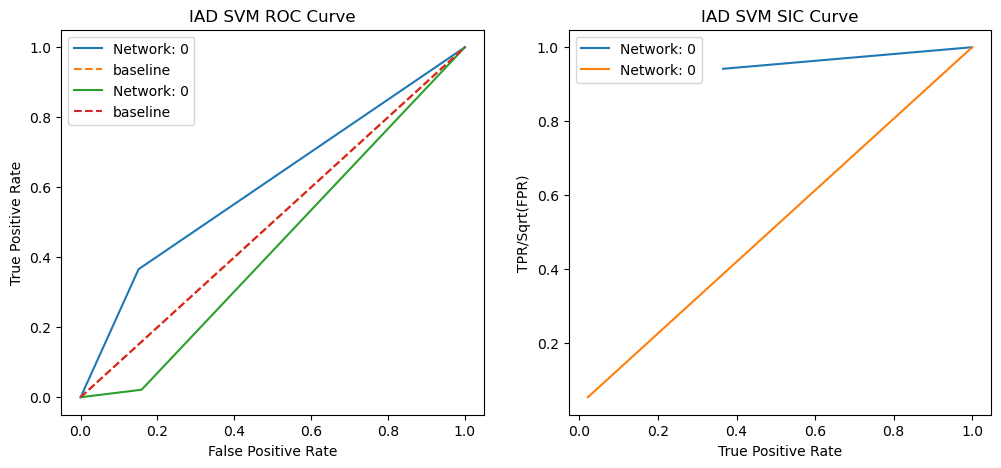

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
make_plots(ax1, ax2, [oad_scores], y_test, "OAD SVM")
fig.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
make_plots(ax1, ax2, [iad_scores], y_test, "IAD SVM")
fig.show()

# One-Class Deep SVDD

In [ ]:
sys.path.append('models/Deep-SVDD/Deep-SVDD-PyTorch/src')
from deepSVDD import DeepSVDD

In [ ]:
oc_svdd_scores = []
models = [DeepSVDD('one-class', nu=10, epochs=20).set_network("fc_net5") for _ in range(10)]

for model in models:
    model.train(x_train_loader, n_epochs=epochs, device="cuda:0")
    model.test(x_test_loader)
    _, _, scores = zip(*model.results['test_scores'])
    oc_svdd_scores.append(np.array(scores))

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
make_plots(ax1, ax2, oc_svdd_scores, y_test, "One-class SVDD (nu=10, Epochs=20)")
fig.show()

# Soft-boundary Deep SVDD

In [ ]:
sys.path.append('models/Deep-SVDD/Deep-SVDD-PyTorch/src')
from deepSVDD import DeepSVDD

In [ ]:
oc_svdd_scores = []
models = [DeepSVDD('soft-boundary', nu=15, epochs=10).set_network("fc_net5") for _ in range(10)]

for model in models:
    model.train(x_train_loader, n_epochs=epochs, device="cuda:0")
    model.test(x_test_loader)
    _, _, scores = zip(*model.results['test_scores'])
    oc_svdd_scores.append(np.array(scores))

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
make_plots(ax1, ax2, oc_svdd_scores, y_test, "Soft-boundary SVDD (nu=15, Epochs=10)")
fig.show()